In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pycocotools
from pycocotools import mask
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/train.csv')
print(df1.shape)
df1.sample(5)

(115488, 3)


,id,class,segmentation
92918,case138_day0_slice_0045,stomach,NaN
47066,case135_day0_slice_0025,stomach,NaN
104511,case85_day29_slice_0086,large_bowel,31204 13 31563 16 31922 19 31943 5 32281 29 32...
86973,case20_day24_slice_0080,large_bowel,16919 3 17180 10 17446 10 17711 12 17730 6 179...
101528,case78_day30_slice_0099,stomach,31884 5 32239 13 32596 18 32954 23 33312 27 33...


In [4]:
# Metadata
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    if (subset=="train") or (DEBUG):
        # DIR="../input/uw-madison-gi-tract-image-segmentation/train"
        DIR="/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/train"
    else:
        # DIR="../input/uw-madison-gi-tract-image-segmentation/test"
        DIR="/content/drive/MyDrive/Kaggle/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #print(df['id'])
    #--------------------------------------------------------------------------
    df["filename"] = df["path"].apply(lambda x: x.split('/')[-1])
    df['unique_filename'] = df.apply(lambda row: str(row.case) + '_' + str(row.day)+'_'+str(row.filename), axis=1)

    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    df["px_spacing_h"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4][:4]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    # new_col_order = ["id", "path", "segmentation"
    #                  "height", "width", "px_spacing_h", 
    #                  "px_spacing_w",  "case",  "day", "slice",]

    # if subset!="train": 
    #   new_col_order.insert(1, "class")

    # new_col_order = [_c for _c in new_col_order if _c in df.columns]
    # df = df[new_col_order]
    return df

In [5]:
df1 = preprocessing(df1, subset="train")
df1.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5


In [11]:
df1.columns


Index(['id', 'class', 'segmentation', 'case', 'day', 'slice', 'path',
       'filename', 'unique_filename', 'width', 'height', 'px_spacing_h',
       'px_spacing_w'],
      dtype='object')

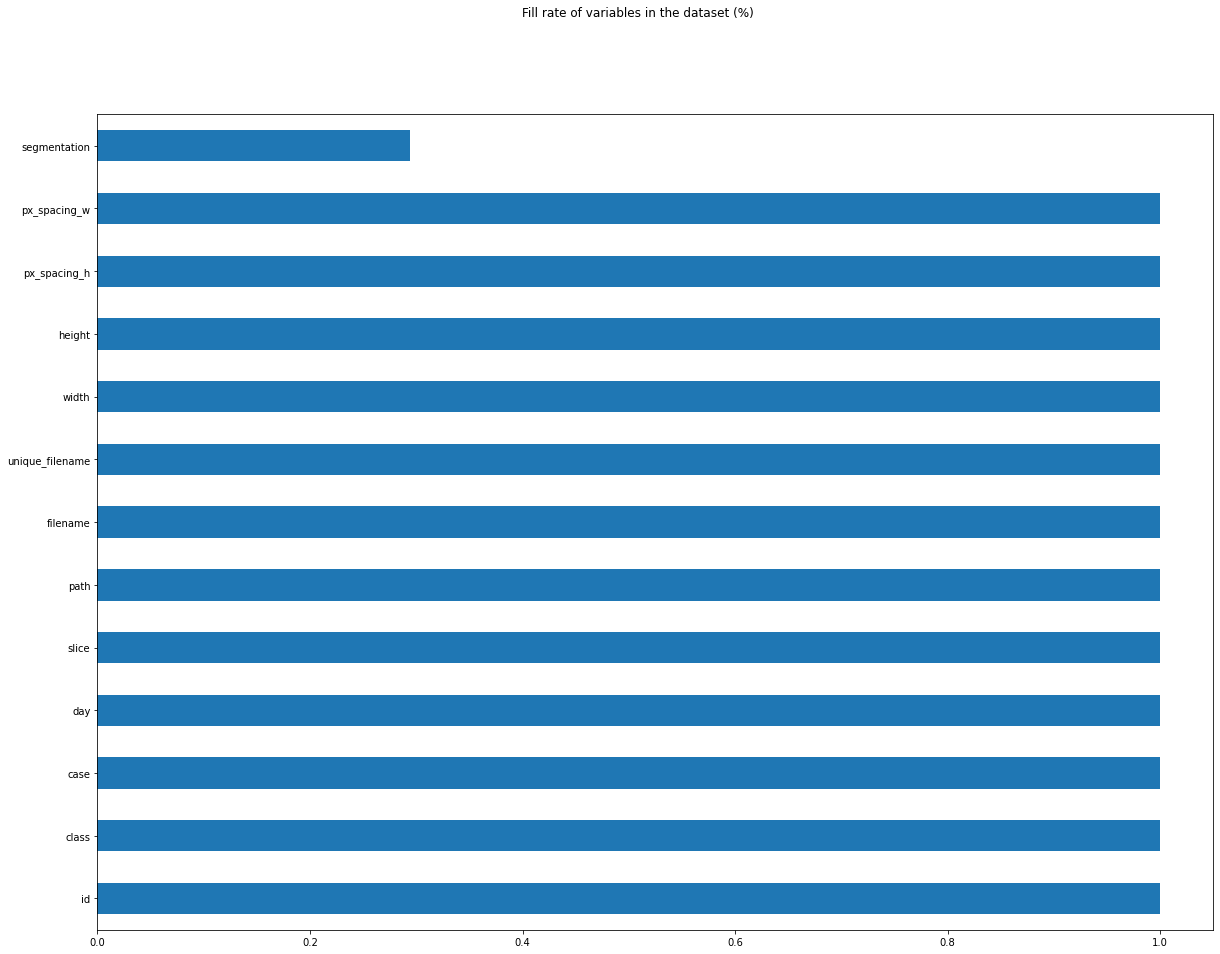

In [12]:
me = (df1.notna().mean(axis=0)).sort_values(ascending=False)
plt.suptitle("Fill rate of variables in the dataset (%)")
me.plot(kind='barh', figsize=(20, 15))

In [13]:
df1[df1['segmentation'].isnull()].shape


(81579, 13)

In [14]:
df1[df1['segmentation'].notnull()].shape


(33921, 13)

In [6]:
# Remove misslabeled training data
df1 = df1[(df1['case'] != 7) | (df1['case'] != 0)].reset_index(drop=True)
df1 = df1[(df1['case'] != 81) | (df1['case'] != 30)].reset_index(drop=True)


In [16]:
df_with_mask = df1[df1['segmentation'].notnull()].copy()
df_with_mask["segmentation"] = df1["segmentation"].astype("str")
df_with_mask = df_with_mask.reset_index(drop=True)
df_with_mask.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,1.5,1.5


In [11]:
def segment(df_with_mask):
  final_df = pd.DataFrame({'id' : df_with_mask['id'][::3]})

  # final_df['lb_seg'] =df1[df1["class"]=="large_bowel"]["segmentation"]
  # final_df['sb_seg'] = df1[df1["class"]=="small_bowel"]["segmentation"]
  # final_df['st_seg']  = df1[df1["class"]=="stomach"]["segmentation"]
  final_df['large_bowel'] = df_with_mask['segmentation'][::3].values
  final_df['small_bowel'] = df_with_mask['segmentation'][1::3].values
  final_df['stomach'] = df_with_mask['segmentation'][2::3].values

  final_df['case'] =  df_with_mask['case'][::3].values
  final_df['day'] =  df_with_mask['day'][::3].values
  final_df['slice'] =  df_with_mask['slice'][::3].values
  final_df['path'] =  df_with_mask['path'][::3].values
  final_df['width'] =  df_with_mask['width'][::3].values
  final_df['height'] =  df_with_mask['height'][::3].values
  final_df['px_spacing_h'] =  df_with_mask['px_spacing_h'][::3].values
  final_df['px_spacing_w'] =  df_with_mask['px_spacing_w'][::3].values
  # final_df = final_df.drop_duplicates(subset=["id"])

  final_df.reset_index(inplace=True,drop=True)
  final_df.fillna('',inplace=True)
  final_df['count'] = np.sum(final_df.iloc[:,1:4]!='',axis=1).values
  train_df  = final_df.copy()
  final_df.sample(2)
  return train_df

df_train = segment(df1)

In [18]:
df_with_mask.to_csv('/content/drive/MyDrive/Kaggle/train_with_mask.csv', index= False)

In [19]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/train_with_mask.csv')
train.head()

,id,class,segmentation,case,day,slice,path,filename,unique_filename,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,65,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,66,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,67,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,68,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,69,/content/drive/MyDrive/Kaggle/uw-madison-gi-tr...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,1.5,1.5


In [8]:
# HELPER FUNCTIONS

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    # einfach nur n konstruktor
    def __init__(self, df, batch_size = BATCH_SIZE, width=128, height=128, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.on_epoch_end()

    # ohne self = static
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,self.width,self.height,3))
        y = np.empty((self.batch_size,self.width,self.height,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    masks = cv2.resize(masks, (self.width, self.height))
                    y[i,:,:,k] = masks
        if self.subset == 'train': 
          return X, y
        else: 
          return X
        
        
    # lädt bild und resized es     
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


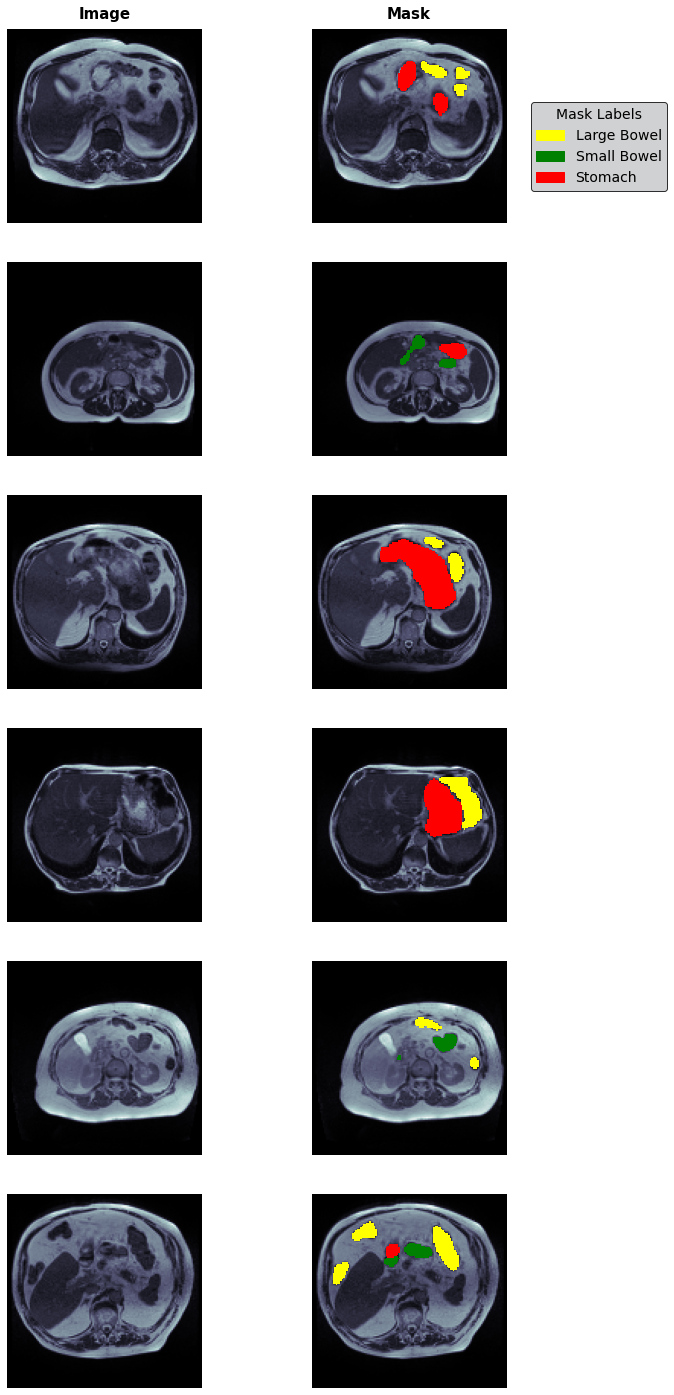

In [14]:
# Visualize Slices
# SAMPLES
BATCH_SIZE=16
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True,width=128, height=128)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]